# Project: Classification

In [45]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

## Part 1. Getting to Know the Data, Handling Missing Values and Outliers


### Task 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# Explore the data for missing values. Where and how many are there?
# your code:
print(f'Only {df.columns[df.isna().any()][0]} feature has {df[df["balance"].isnull()].shape[0]} missing values.')


Only balance feature has 25 missing values.


### Task 2

In [5]:
# Are there any missing values in the 'job' feature? Perhaps they are indicated by some special word?
# your code:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Task 3

In [6]:
# transform balance feature such that it could be smoothly converted into float
df.balance = df.balance.apply(lambda x: np.NAN if type(x) is float else (float(x[:-6].replace(' ', '')) if len(x)>5 else 0))

In [7]:
# Calculate the mean value using the balance feature converted to float. 
# Round your answer to three decimal spaces after the separator.
round(df.balance.mean(), 3)

1529.129

### Task 4

In [8]:
# fill NAN's with median values 
df.balance.fillna(np.median(df[~df['balance'].isnull()]['balance']), inplace=True)

In [9]:
# Calculate the mean value of the balance transformed into the correct form. 
# Round the answer to three digits after the separator point.
round(df.balance.mean(), 3)

1526.936

### Task 5

In [10]:
# fill NANs in cat features (job and education), with mode
# your code:
# filling unknown's for jobs
df.job = df.job.apply(lambda x: df.job.mode()[0] if x == 'unknown' else x)
# and fo education
df.education = df.education.apply(lambda x: df.education.mode()[0] if x == 'unknown' else x)

In [11]:
# After replacing the blanks, calculate the average balance for clients with the most popular job 
# and the most popular level of education. Round the answer to three digits after the separator point.
round(df[(df['education'] == df['education'].value_counts(ascending=False).index[0]) & 
         (df['job'] == df['job'].value_counts(ascending=False).index[0])]['balance'].mean(), 3)

1598.883

### Task 6

In [12]:
# remove all outliers in df['balance'] (using Tukey method)
# here I bring some function from the days long gone :)
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[~((x<lower_bound) | (x > upper_bound))]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bond, upper_bond = outliers_iqr(df, 'balance')

print(f'Outliers number: {outliers.shape[0]}')
print(f'Cleaned values number: {cleaned.shape[0]}')
print(f'Lower bond is {lower_bond}, upper bond is {upper_bond}')


Outliers number: 1057
Cleaned values number: 10105
Lower bond is -2241.0, upper bond is 4063.0


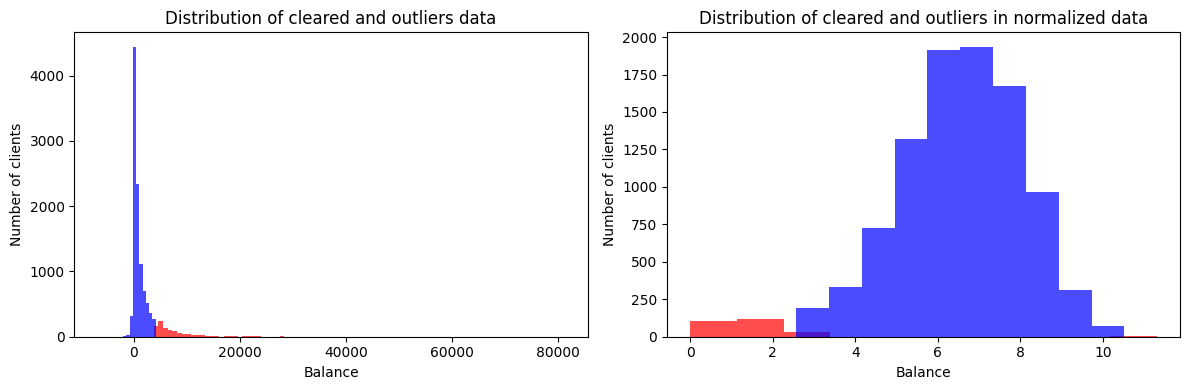

In [13]:
# We removed outliers without checking the feature distribution?
# not good. Let's check it!
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Let's plot outliers and cleaned data near each other
axes[0].hist(outliers['balance'], bins=100, alpha=0.7, color='red', label='Outliers')
axes[0].hist(cleaned['balance'], alpha=0.7, color='blue', label='Cleaned')
axes[0].set_title('Distribution of cleared and outliers data')
axes[0].set_xlabel('Balance')
axes[0].set_ylabel('Number of clients')
# it looks that our distribution is closer to log-normal and we had to convert it to normal firstly

df_norm = copy.deepcopy(df)
df_norm['balance'] = np.log(df[df['balance'] > 0]['balance']) # or we get -∞
outliers_norm, cleaned_norm, _, _ = outliers_iqr(df_norm, 'balance')

# Let's plot outliers and cleaned data near each other
axes[1].hist(outliers_norm['balance'], alpha=0.7, color='red', label='Outliers')
axes[1].hist(cleaned_norm['balance'], alpha=0.7, color='blue', label='Cleaned')
axes[1].set_title('Distribution of cleared and outliers in normalized data')
axes[1].set_xlabel('Balance')
axes[1].set_ylabel('Number of clients')

plt.tight_layout()
plt.show()

# See? only now these data make some sense. In the first case we just got rid of people
# who "dared" to have some above average sum on their account.
# however, task was clear - remove outliers and don't ask questions :/

## Part 2:  Exploratory Data Analysis

### Task 1:

In [14]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [15]:
cleaned.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

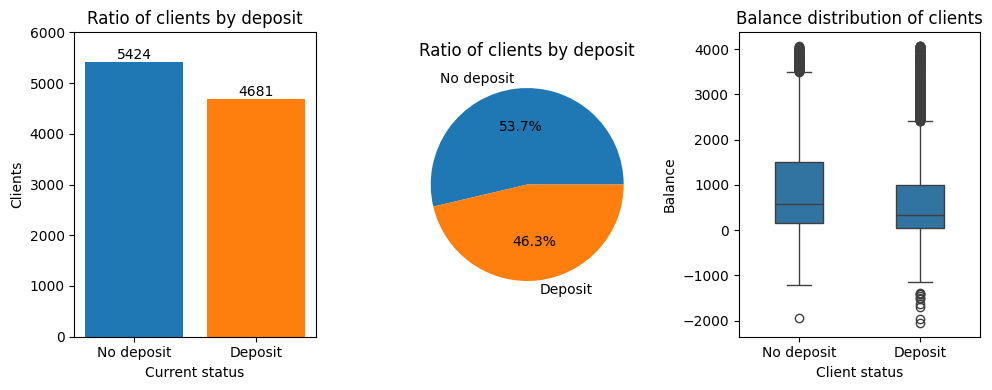

In [16]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
# barplot
axes[0].bar(x=['No deposit', 'Deposit'], 
            height=cleaned.groupby('deposit').size(),
            color=['tab:blue', 'tab:orange'])
axes[0].set_title('Ratio of clients by deposit')
axes[0].set_xlabel('Current status');
axes[0].set_ylabel('Clients');
axes[0].set_ylim([0,6000])

# Add y values for each x value
for i, v in enumerate(cleaned.groupby('deposit').size()):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# pieplot
axes[1].pie(cleaned.groupby('deposit').size(),
            labels=['No deposit', 'Deposit'],
            autopct='%.1f%%')
axes[1].set_title('Ratio of clients by deposit')

# your code

# boxplot
sns.boxplot(
    data=cleaned,
    x='deposit',
    y='balance',
    width=0.4,
    ax=axes[2]
)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['No deposit', 'Deposit'])
axes[2].set_title('Balance distribution of clients', fontsize=12)
axes[2].set_xlabel('Client status', fontsize=10)
axes[2].set_ylabel('Balance', fontsize=10)
plt.tight_layout()
plt.show()

### Tasks 2 & 3

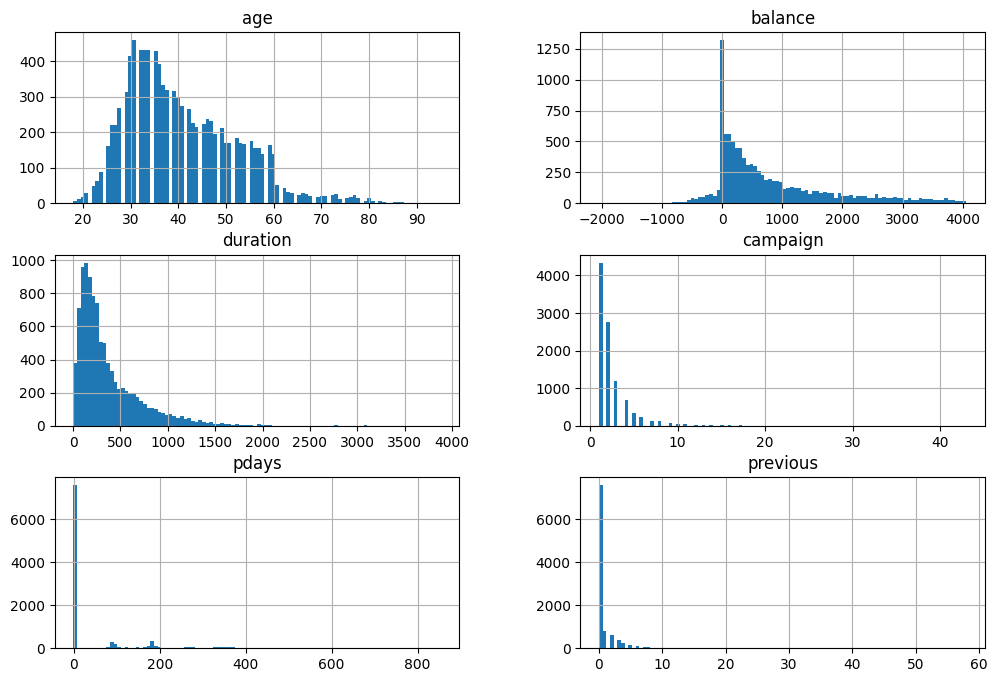

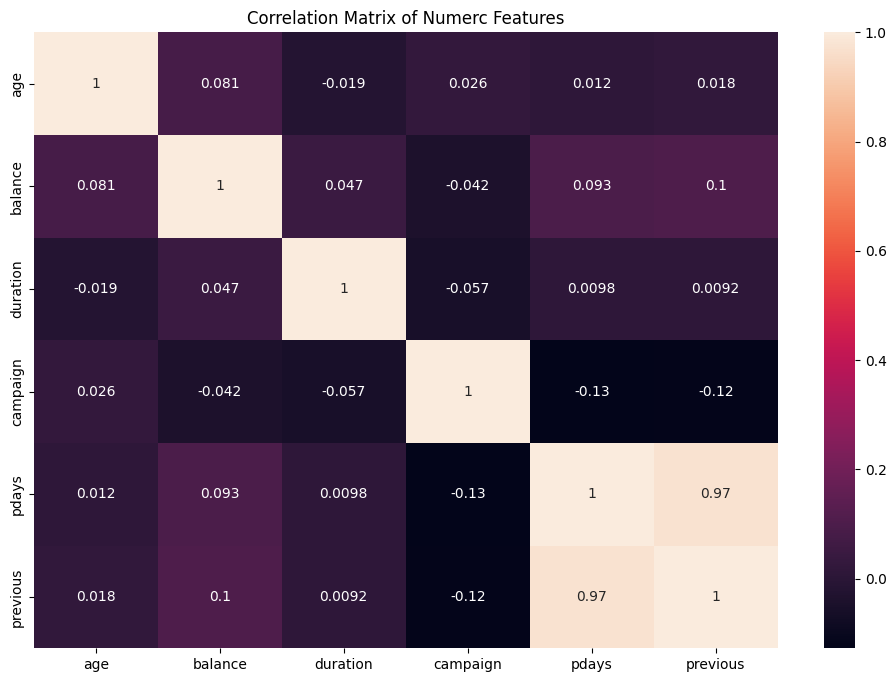

,age,balance,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,3881.000000,43.000000,854.000000,58.000000


In [17]:
# Calculate descriptive statistics for quantitative variables, interpret the result.

# our brain is not meant to draw any conclusions while staring at bare numbers,
# firstly let's divide categorical and numerical data
cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day','month', 'poutcome', 'deposit']
# you can disagree, but 'day' for me is same cat feature as month
# numeric columns:
num_col = ['age', 'balance','duration', 'campaign', 'pdays', 'previous']
cat_df = cleaned[cat_col]
num_df = cleaned[num_col]
# let's visualize distributions of numeric features with histograms
num_df.hist(figsize=[12,8], bins=100)
# now let's see if features are correlated within df 
# (we use spearman correlation because our data are mostly non-normally distributed)
correlation_matrix = num_df.corr('spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Numerc Features')
plt.show()
# showing statistics
num_df.describe()

#### Overview of quantitative features:
1. Most features have log distribution (except of pdays);
2. Most of features are not correlated (or correlated weakly), with exception of pdays and previous are strongly correlated with corr coef = 0.97;
3. Short description of features:
    - **age**: Looks like skewed normal distribution or log distribution with one interesting feature - amount of clients drops sharply for clients older than 60. What can be the reason? Are people choosing another bank for operations with retirement deposits? 
    - **balance**: Log distribution (if fact two distributions crammed together) with most clients feeling uncomfortable going below 0. Aount of "inactive" accounts looks quite high - we've got a huge peak at 0 mark;
    - **duration**: Looks like log distribution, no strong correlation with any other feature;
    - **campaign**: Looks like log distribution, no strong correlation with any other feature;
    - **pdays**: as mentioned above - most of values are -1's (probably mark that clients were never contacted), rest of data has rather log distributin (plot below). pdays have strong correlation with 'previous' feature.
    - **previous**: Looks like log distribution. Amount of clients which 0 contact nuber fits perfectly with -1 value of pdays feature (see below);
#### Intermediate summary:
Data should be converted to normal distribution. pdays and previous are redundant. I would drop pdays, as it has some "symbolic" values (-1), while previous is a simple numeric feature.

Classes of the deposit feature are relativelly balanced.


### Tasks 4 & 5

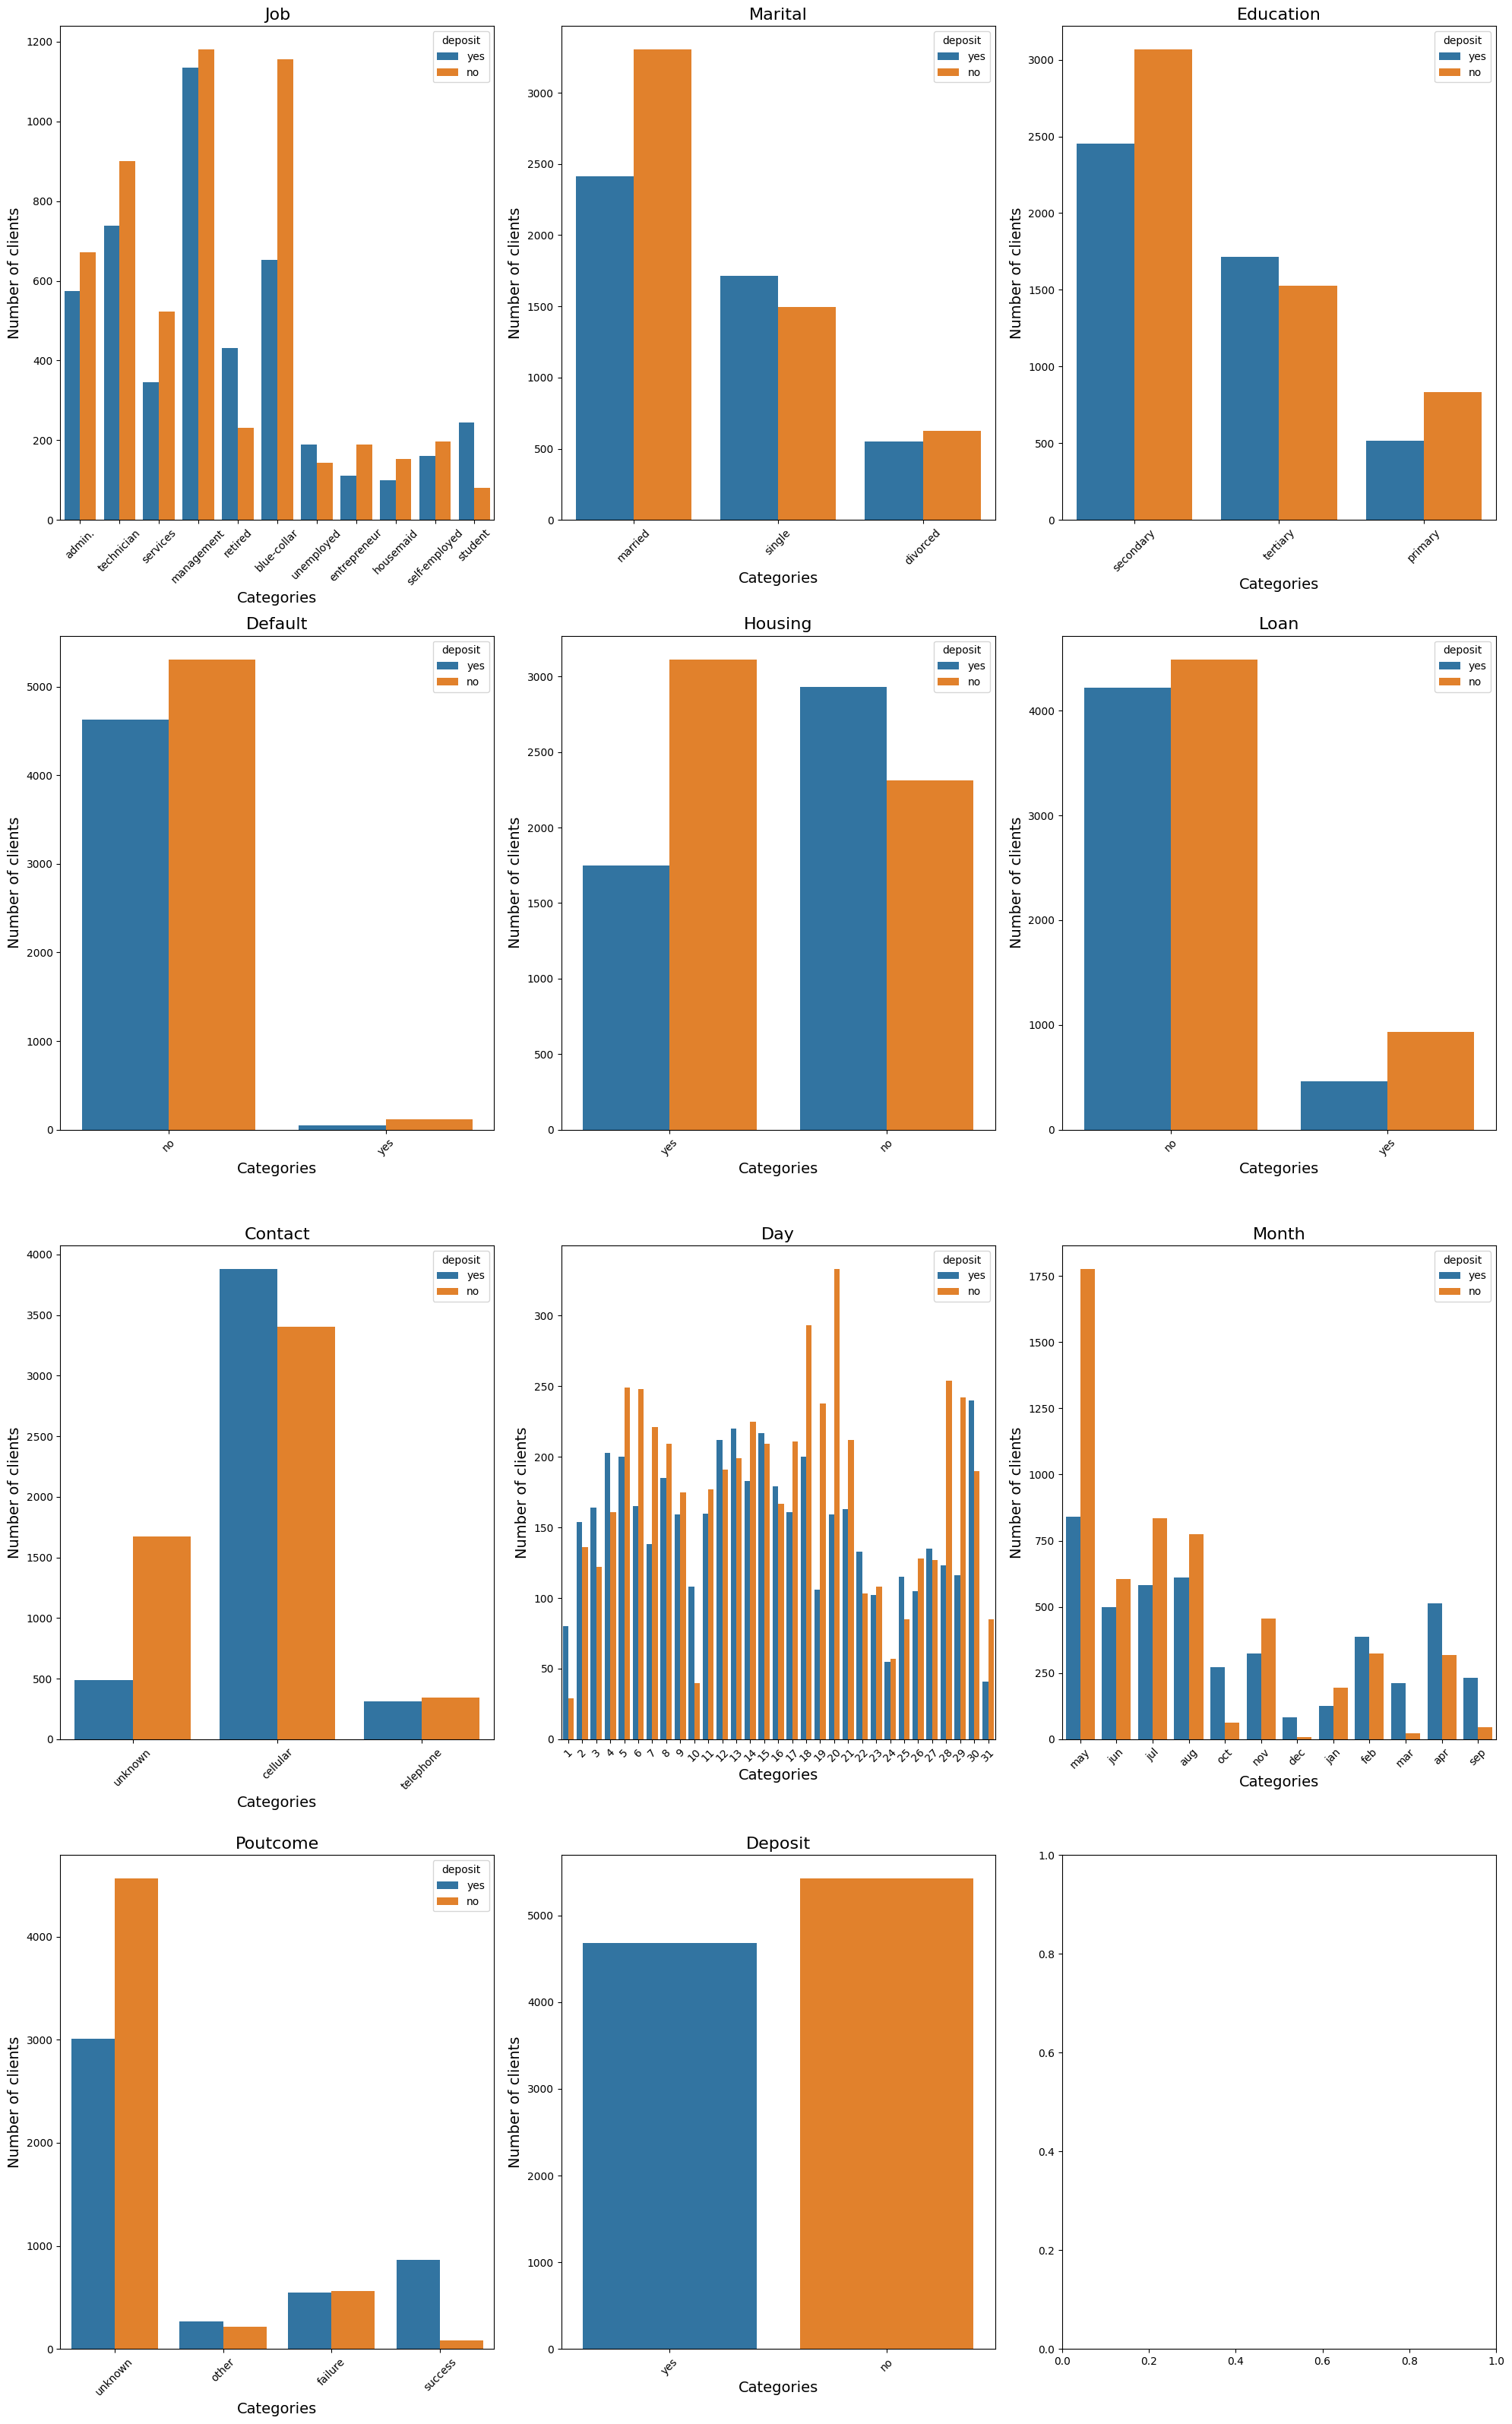

,job,marital,education,default,housing,loan,contact,day,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,31,12,4,2
top,management,married,secondary,no,no,no,cellular,18,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,493,2617,7570,5424


In [18]:
#calculate descriptive statistics for categorical variables, interpret the result
#build visualizations to illustrate the results

# Visualization (plotting frequences)
# Get the number of columns and rows for the subplots
num_cols = len(cat_df.columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 8*num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and plot the frequencies
for i, column in enumerate(cat_df.columns):
    ax = axes[i]
    barplot = sns.countplot(
        data=cat_df,
        x=column,
        hue='deposit',
        ax=ax,

    )
    barplot.set_title(column.capitalize(), fontsize=16)
    barplot.set_ylabel('Number of clients', fontsize=14)
    barplot.set_xlabel('Categories', fontsize=14)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)  # Rotate xtick labels by 45 degrees

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
# some boring statistics table
cat_df.astype('object').describe()


### Task 6

In [19]:
# Find out for which status of the previous marketing campaign success in the current one prevails over the number of failures.

# Creating contingency table of poutcome and deposit features
ct = pd.crosstab(cat_df['poutcome'], cat_df['deposit'])
# filtering only those 'potcome'values where 'deposit' values are predominantly 'yes'
ct[(ct.loc[:,'yes'] - ct.loc[:,'no']) > 0].index

Index(['other', 'success'], dtype='object', name='poutcome')

### Task 7

In [20]:
# Find out which month was the most likely one to turn down an offer to open a deposit
# Creating contingency table of month and deposit features
month_ct = pd.crosstab(cat_df['month'], cat_df['deposit'])
# filtering only those 'month'values where 'deposit' values are overhelmingly 'no'
month_ct[(month_ct.loc[:,'no'] / month_ct.loc[:,'yes']) == (month_ct.loc[:,'no'] / month_ct.loc[:,'yes']).max()].index

Index(['may'], dtype='object', name='month')

### Task 8

In [21]:
# create age groups and determine which groups are more likely to open a deposit than decline an offer
# creating sorter function:
def age_coder(age):
    if int(age) < 30:
        return '<30'
    elif int(age) < 40:
        return '30-39'
    elif int(age) < 50:
        return '40-49'
    elif int(age) <= 60:
        return '50-59'
    else:
        return '60+'
# adding new feature to cat_df:
cat_df['age_cat'] = num_df['age'].apply(age_coder)
# doing same stuff as before
ct = pd.crosstab(cat_df['age_cat'], cat_df['deposit'])
ct[(ct.loc[:,'yes'] - ct.loc[:,'no']) > 0].index

Index(['60+', '<30'], dtype='object', name='age_cat')

### Tasks 9 and 10 (done in tasks 4&5)

### Task 11

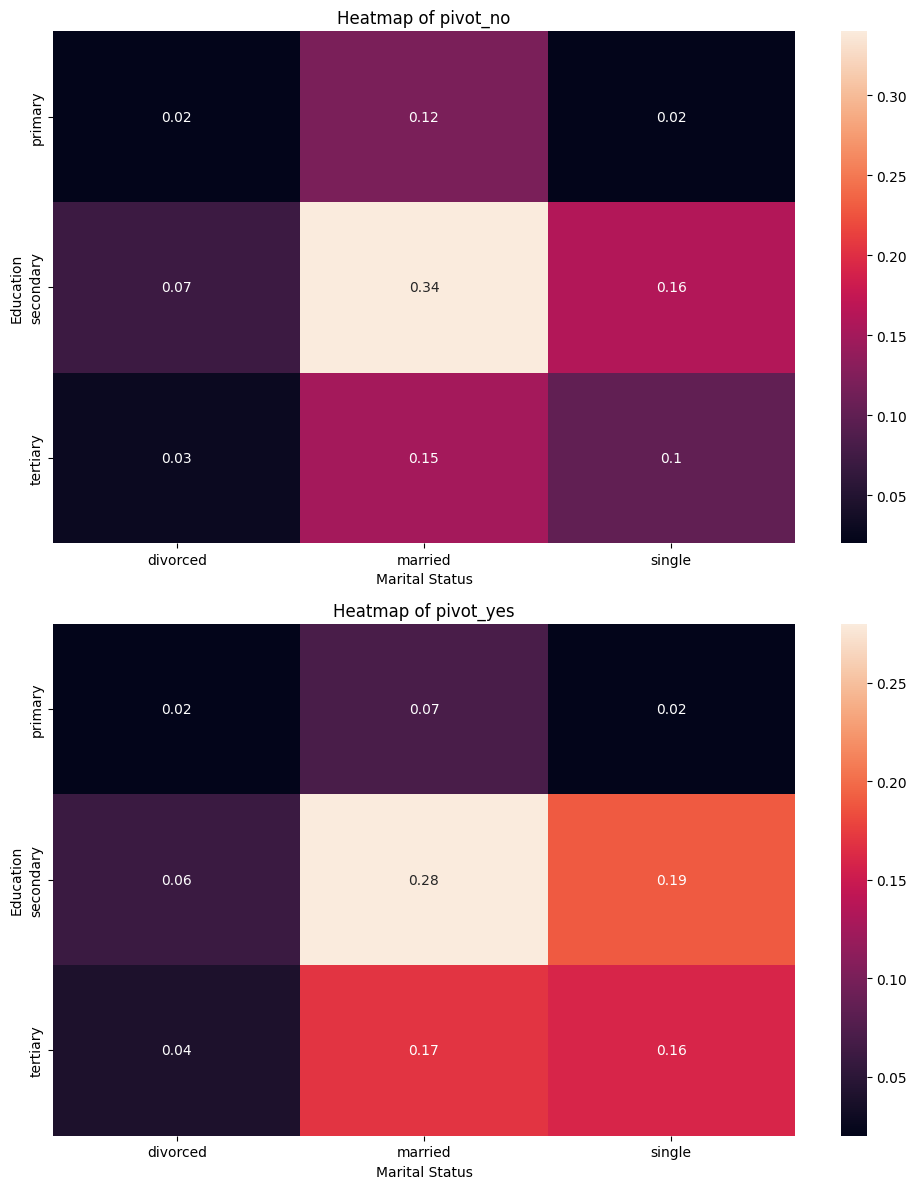

In [22]:
# construct a pivot table to determine which people with which education and marital status are the most numerous
#(when considering those who have opened a deposit)
# creating separate DF for different deposit status
pivot_yes = pd.pivot_table(cat_df[cat_df['deposit']=='yes'], values='deposit', index=['education'], columns=['marital'], aggfunc='count')
pivot_no = pd.pivot_table(cat_df[cat_df['deposit']!='yes'], values='deposit', index=['education'], columns=['marital'], aggfunc='count')
# Creating heatmaps
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot pivot_no
sns.heatmap(round(pivot_no / cat_df[cat_df['deposit']!='yes'].shape[0],2), annot=True, ax=axes[0])
axes[0].set_title('Heatmap of pivot_no')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Education')

# Plot pivot_yes
sns.heatmap(round(pivot_yes / cat_df[cat_df['deposit']=='yes'].shape[0],2), annot=True, ax=axes[1])
axes[1].set_title('Heatmap of pivot_yes')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Education')

plt.tight_layout()
plt.show()


## Part 3: Data Conversion

### Task 1

In [23]:
# convert education levels
label_encoder = LabelEncoder()
cat_df['education']= label_encoder.fit_transform(cat_df['education'])
# convert age groups by label encoding
label_encoder = LabelEncoder()
cat_df['age_cat']= label_encoder.fit_transform(cat_df['age_cat'])


### Task 2 and 3

In [24]:
# convert binary variables to 0's and 1's
# let's find these binary features firstly:
binary_features = []
for column in cat_df:
    if cat_df[column].nunique() ==2:
        binary_features.append(column)

# now, let's convert them into 0 and 1s
for col in binary_features:
    cat_df[col] = cat_df[col].map({'yes': 1, 'no': 0})

# get std for freshly-encoded feature 'deposit':
print(f'A standard deviation of the deposit feature is {round(cat_df["deposit"].std(), 3)}')

# Calculate mean for each of the resulting ['default','housing','loan'] binary variables,
# add results up and enter the total as the answer, 
# rounding it to three decimal places after the separator point.
cat_df[['default','housing','loan']]
print(f"The sum of new binary features means is {round(cat_df[['default','housing','loan']].apply(np.mean).sum(), 3)}")

A standard deviation of the deposit feature is 0.499
The sum of new binary features means is 0.635


### Task 4

In [25]:
# Encode all nominative colors with one-hot encoder
nom_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
onehot_encoder = OneHotEncoder()
# creatting 2d array with encoded features
cat_df_onehot = onehot_encoder.fit_transform(cat_df[nom_cols]).toarray()
# getting new features names
columns = onehot_encoder.get_feature_names_out(nom_cols)
# turning it to df
cat_df_onehot = pd.DataFrame(cat_df_onehot, columns=columns)
# concating dfs
cat_df.reset_index(drop=True, inplace=True)
num_df.reset_index(drop=True, inplace=True)
cat_df_encoded = pd.concat([cat_df, cat_df_onehot], axis=1)
# concating cat_df and num_dfs back
df = pd.concat([cat_df_encoded, num_df], axis=1)
# deleting non-encoded columns:
df.drop(nom_cols, inplace=True, axis=1)


### Tasks 5 and 6

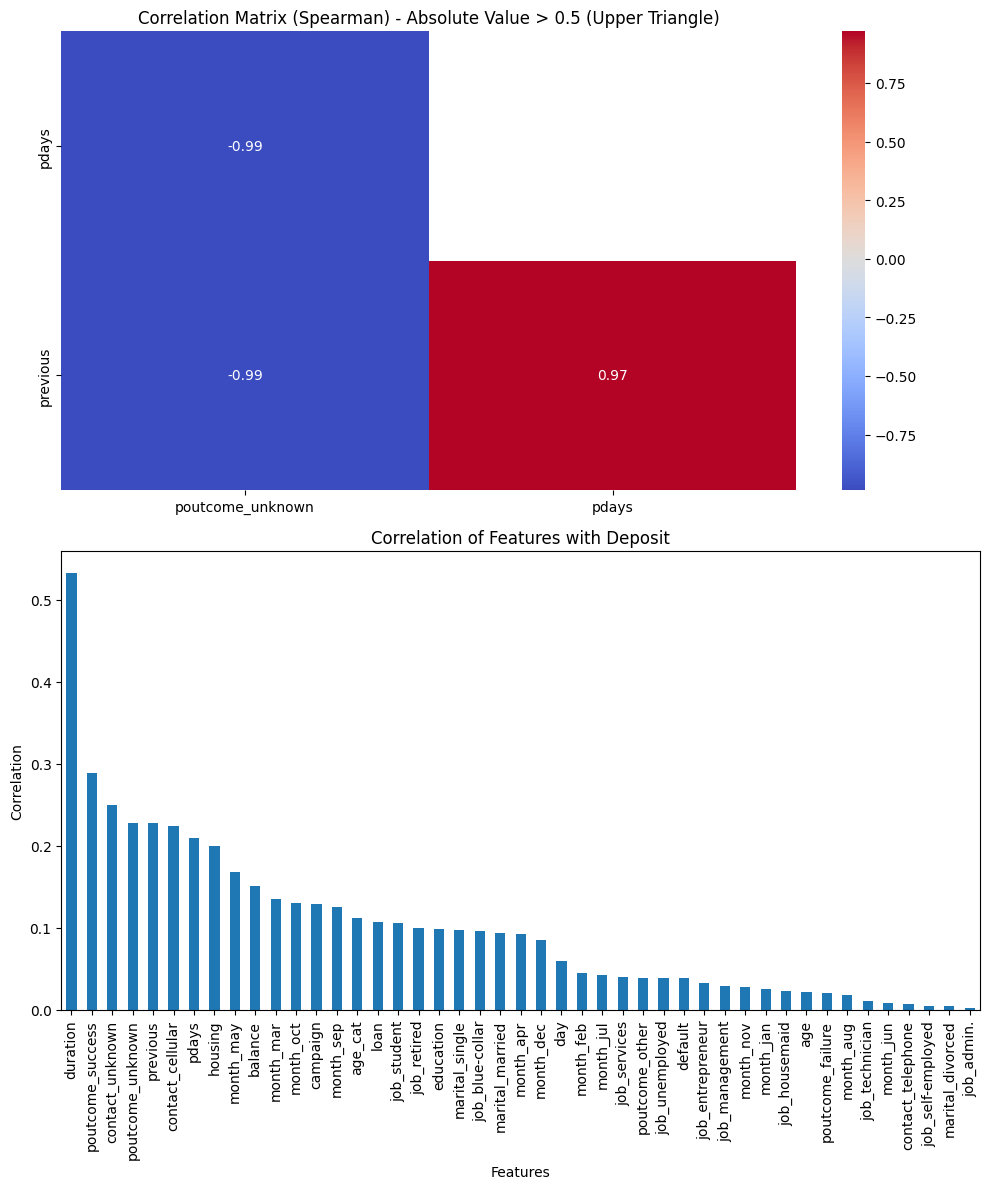

Most correlated features are {'previous', 'poutcome_unknown', 'pdays'}


In [26]:
import matplotlib.pyplot as plt

# Calculate the correlation matrix using the Spearman coefficient (categorical + non-norm distirbuted values)
correlation_matrix = df.corr(method='spearman')

# Filter the correlation matrix to include only coefficients with absolute value greater than 0.5
filtered_corr_matrix = correlation_matrix[abs(correlation_matrix) > 0.9]

# Showing only upper triangle we don't show self-correlation and we can make all heatmap much more compact
# deleting rows where all values don't comply with filter parameters
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))

# Apply the mask to the filtered correlation matrix
masked_corr_matrix = filtered_corr_matrix.mask(mask)
masked_corr_matrix.dropna(how='all', axis=0, inplace=True)  # Drop rows where all values are NaN
masked_corr_matrix.dropna(how='all', axis=1, inplace=True)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot the heatmap of the masked correlation matrix
sns.heatmap(masked_corr_matrix, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (Spearman) - Absolute Value > 0.9 (Upper Triangle)')

# Now we will vizualize top correlated features with the target 'deposit" feature
# Extract the correlation values for the deposit feature
deposit_corr = correlation_matrix['deposit'].drop('deposit')

# Make all values positive (for convenience)
abs(deposit_corr).sort_values(ascending=False).plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Correlation of Features with Deposit')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

# printing highly correlated features:
print(f'Most correlated features are {set(masked_corr_matrix.columns.append(masked_corr_matrix.index))}')

### Task 7 / 8

In [27]:
# splitting data on test and train
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [28]:
# what is the size of the train sample?
print(X_test.shape[0])
# What is y_train mean value?
print(round(np.mean(y_train),2))

3335
0.46


### Task 9

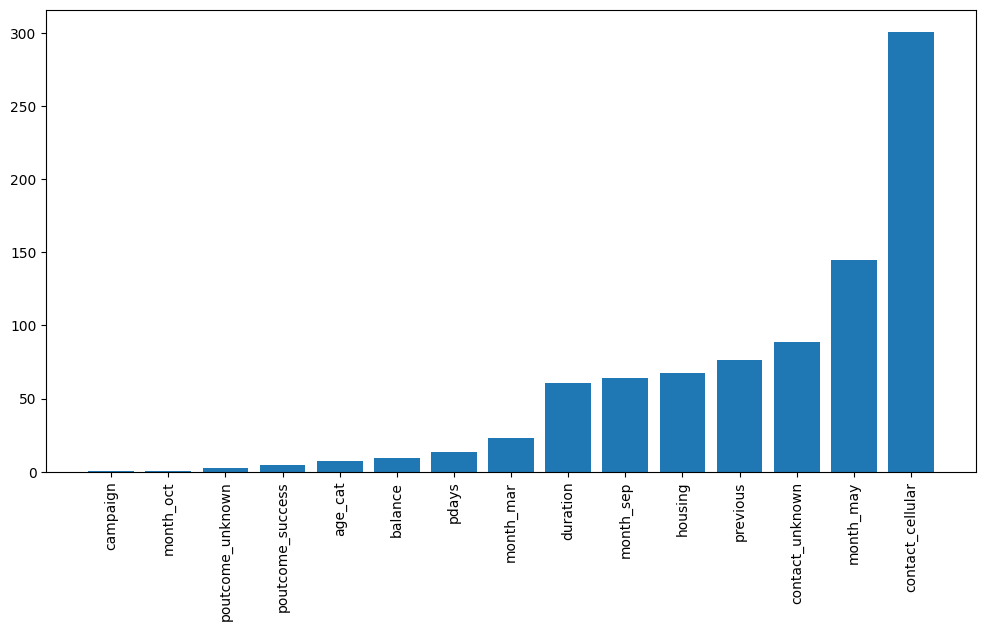

In [29]:
# with SelectKBest select 15 most informative features features
from itertools import compress
skb = SelectKBest(f_classif, k=15).fit(X_train, y_train)
mask = skb.get_support()
name_col = X_train.columns.values
result = list(compress(name_col, mask))
score_skb = skb.scores_
sorted_data = sorted(zip(result, score_skb[:15]), key=lambda x: x[1])

result_sorted, score_skb_sorted = zip(*sorted_data)

plt.figure(figsize=(12, 6))  # Set the figure size to 12 inches by 6 inches
plt.bar(result_sorted, score_skb_sorted)
plt.xticks(rotation=90)
plt.show()

# selecting only those 15 columns:
X_train = X_train[list(result_sorted)]
X_test = X_test[list(result_sorted)]

### Задание 10

In [30]:
# normalize your data with minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
np.round(np.mean(X_train_scaled[:,0]), 2)

0.04

# Part 4: Solving the classification problem: logistic regression and decision trees

### Task 1 Logistic Regression

In [43]:
from sklearn import linear_model, metrics

log_reg_bank = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
# Training
log_reg_bank.fit(X_train_scaled, y_train)
# Prediction on train data
y_pred_train = log_reg_bank.predict(X_train_scaled)
# Prediction on test data
y_pred_test = log_reg_bank.predict(X_test_scaled)


# Showing all metrics for train and test data
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335



### Task decision tree 2,3,4

In [56]:
# train the solving trees, set the maximum depth

some_tree = tree.DecisionTreeClassifier(
    criterion= "entropy", 
    random_state=42
)
# Training
some_tree.fit(X_train, y_train)

# Prediction on train data
y_pred_train = some_tree.predict(X_train_scaled)
# Prediction on test data
y_pred_test = some_tree.predict(X_test_scaled)
# Metrics
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      3634
           1       0.00      0.00      0.00      3136

    accuracy                           0.54      6770
   macro avg       0.27      0.50      0.35      6770
weighted avg       0.29      0.54      0.37      6770

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1790
           1       0.00      0.00      0.00      1545

    accuracy                           0.54      3335
   macro avg       0.27      0.50      0.35      3335
weighted avg       0.29      0.54      0.37      3335



### Task 5 (Decision tree + GridSearchCV)

In [65]:
from sklearn.metrics import f1_score
# find optimal parameters with gridsearch
param_grid = {'max_depth':[3,5,7],
              'min_samples_split': [2, 5, 7, 10]
             }
grid_search_rf = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid
)  
%time grid_search_rf.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_rf.predict(X_test_scaled)


print(metrics.classification_report(y_test, y_test_pred))
print(grid_search_rf.best_params_)

CPU times: total: 1.09 s
Wall time: 1.13 s
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

{'max_depth': 7, 'min_samples_split': 5}


# Part 5: Classification: ensemble methods

### Task 1 Random Forest

In [62]:
# trying random forest with our data
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Tasks 2 and 3 gradient boosting

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Gradient boosting classifier
gb = GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5, 
    random_state=42, 
    min_samples_leaf=5 
)
# Training
gb.fit(X_train_scaled, y_train)
# Prediction on test data
y_pred = gb.predict(X_test_scaled)
# Metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Task 4 Stacking Classifier

In [66]:
# Assemblingh all tried models to stacking
from sklearn.ensemble import StackingClassifier
estimators = [
    ('lr', linear_model.LogisticRegression(
        random_state=42,
        max_iter=1000, 
        solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(
        max_depth=7, 
        min_samples_split=5)),
    # ('rf', ensemble.RandomForestClassifier(
    #     n_estimators=100,
    #     max_depth=10,
    #     criterion='gini',
    #     min_samples_leaf=5,
    #     random_state=42
    # )),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, 
        n_estimators=300, 
        max_depth=5, 
        random_state=42, 
        min_samples_leaf=5
    ))

]

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
)
# training
reg.fit(X_train_scaled, y_train)
# prediction
y_pred_stack = reg.predict(X_test_scaled)
# metrics
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Task 5 Feature importance

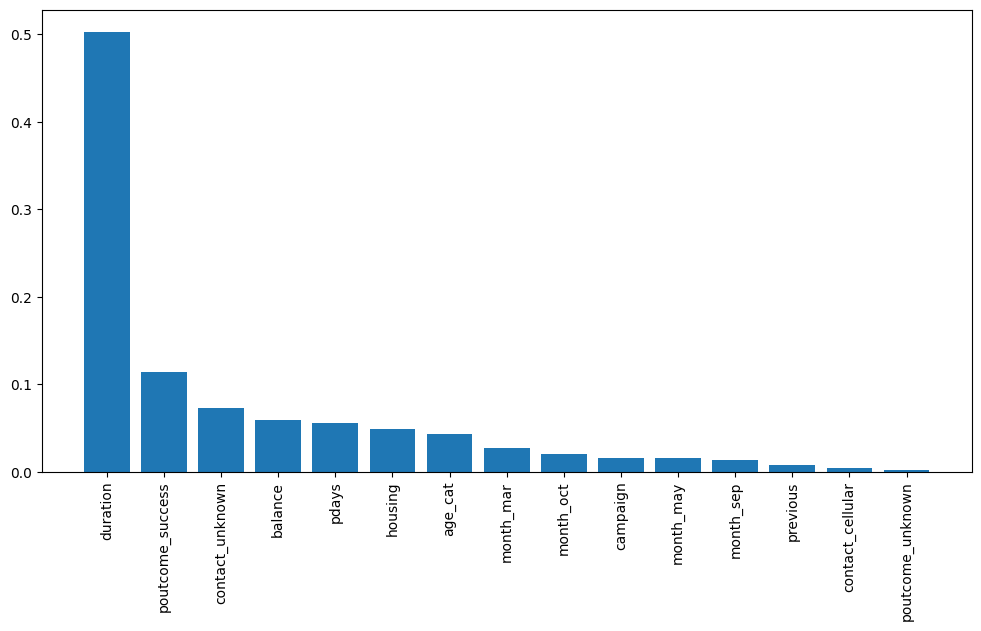

In [74]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importances = gb.feature_importances_
# extract feature names
feature_names = X_train.columns
# zip feature names and feature importance into one object and sort it
feature_importance = sorted(zip(importances, feature_names), reverse=True)
# plot feature importance
plt.figure(figsize=(12, 6))
plt.bar([x[1] for x in feature_importance], [x[0] for x in feature_importance])
plt.xticks(rotation=90)
plt.show()


### Task 6,7,8 Hyperparameter tuning with Optuna

In [76]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.5.0


In [82]:
def optuna_rf(trial):
  # Hyperparameters space
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # define model
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # fit model
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score

In [85]:
%%time
# create a study
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# looking for best parameters
study.optimize(optuna_rf, n_trials=40)
# results for test
print("Best hyperparameters set {}".format(study.best_params))
print("f1_score on train: {:.2f}".format(study.best_value))
# metrics for train
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy on test: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score on test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2024-01-23 09:21:40,856] A new study created in memory with name: RandomForestClassifier
[I 2024-01-23 09:21:42,575] Trial 0 finished with value: 0.8148614609571788 and parameters: {'n_estimators': 119, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8148614609571788.
[I 2024-01-23 09:21:45,045] Trial 1 finished with value: 0.8152344979540447 and parameters: {'n_estimators': 191, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8152344979540447.
[I 2024-01-23 09:21:46,543] Trial 2 finished with value: 0.8144166930129624 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8152344979540447.
[I 2024-01-23 09:21:47,568] Trial 3 finished with value: 0.8161974058842139 and parameters: {'n_estimators': 111, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8161974058842139.
[I 2024-01-23 09:21:49,028] Trial 4 finished with value: 0.8147914032869786 and parameters: {'n_

Best hyperparameters set {'n_estimators': 163, 'max_depth': 12, 'min_samples_leaf': 2}
f1_score on train: 0.82
accuracy on test: 0.83
f1_score on test: 0.82
CPU times: total: 1min 12s
Wall time: 1min 13s
